In [11]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,795 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 148492 files and d

In [1]:
!pip install pycaret

  Using cached pycaret-2.3.3-py3-none-any.whl (264 kB)
  Using cached umap_learn-0.5.1-py3-none-any.whl
  Using cached imbalanced_learn-0.7.0-py3-none-any.whl (167 kB)
  Using cached mlflow-1.20.2-py3-none-any.whl (14.6 MB)
  Using cached pandas_profiling-3.0.0-py2.py3-none-any.whl (248 kB)
  Using cached pyLDAvis-3.3.1.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Using cached pyod-0.9.3-py3-none-any.whl
  Using cached kmodes-0.11.0-py2.py3-none-any.whl (18 kB)
  Using cached lightgbm-3.2.1-py3-none-manylinux1_x86_64.whl (2.0 MB)
  Using cached Boruta-0.3-py3-none-any.whl (56 kB)
  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)
  Using cached yellowbrick-1.3.post1-py3-none-any.whl (271 kB)
  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Using cached mlxtend-0.19.0-py2.py3-none-any.whl (1.3 MB)
  Using cache

In [2]:
!pip install shap

     |████████████████████████████████| 356 kB 3.0 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491644 sha256=a5c6d39cbb9a934ab96860e9083987f9cd70f4a66ab409ed88dcf3a6531605bc
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


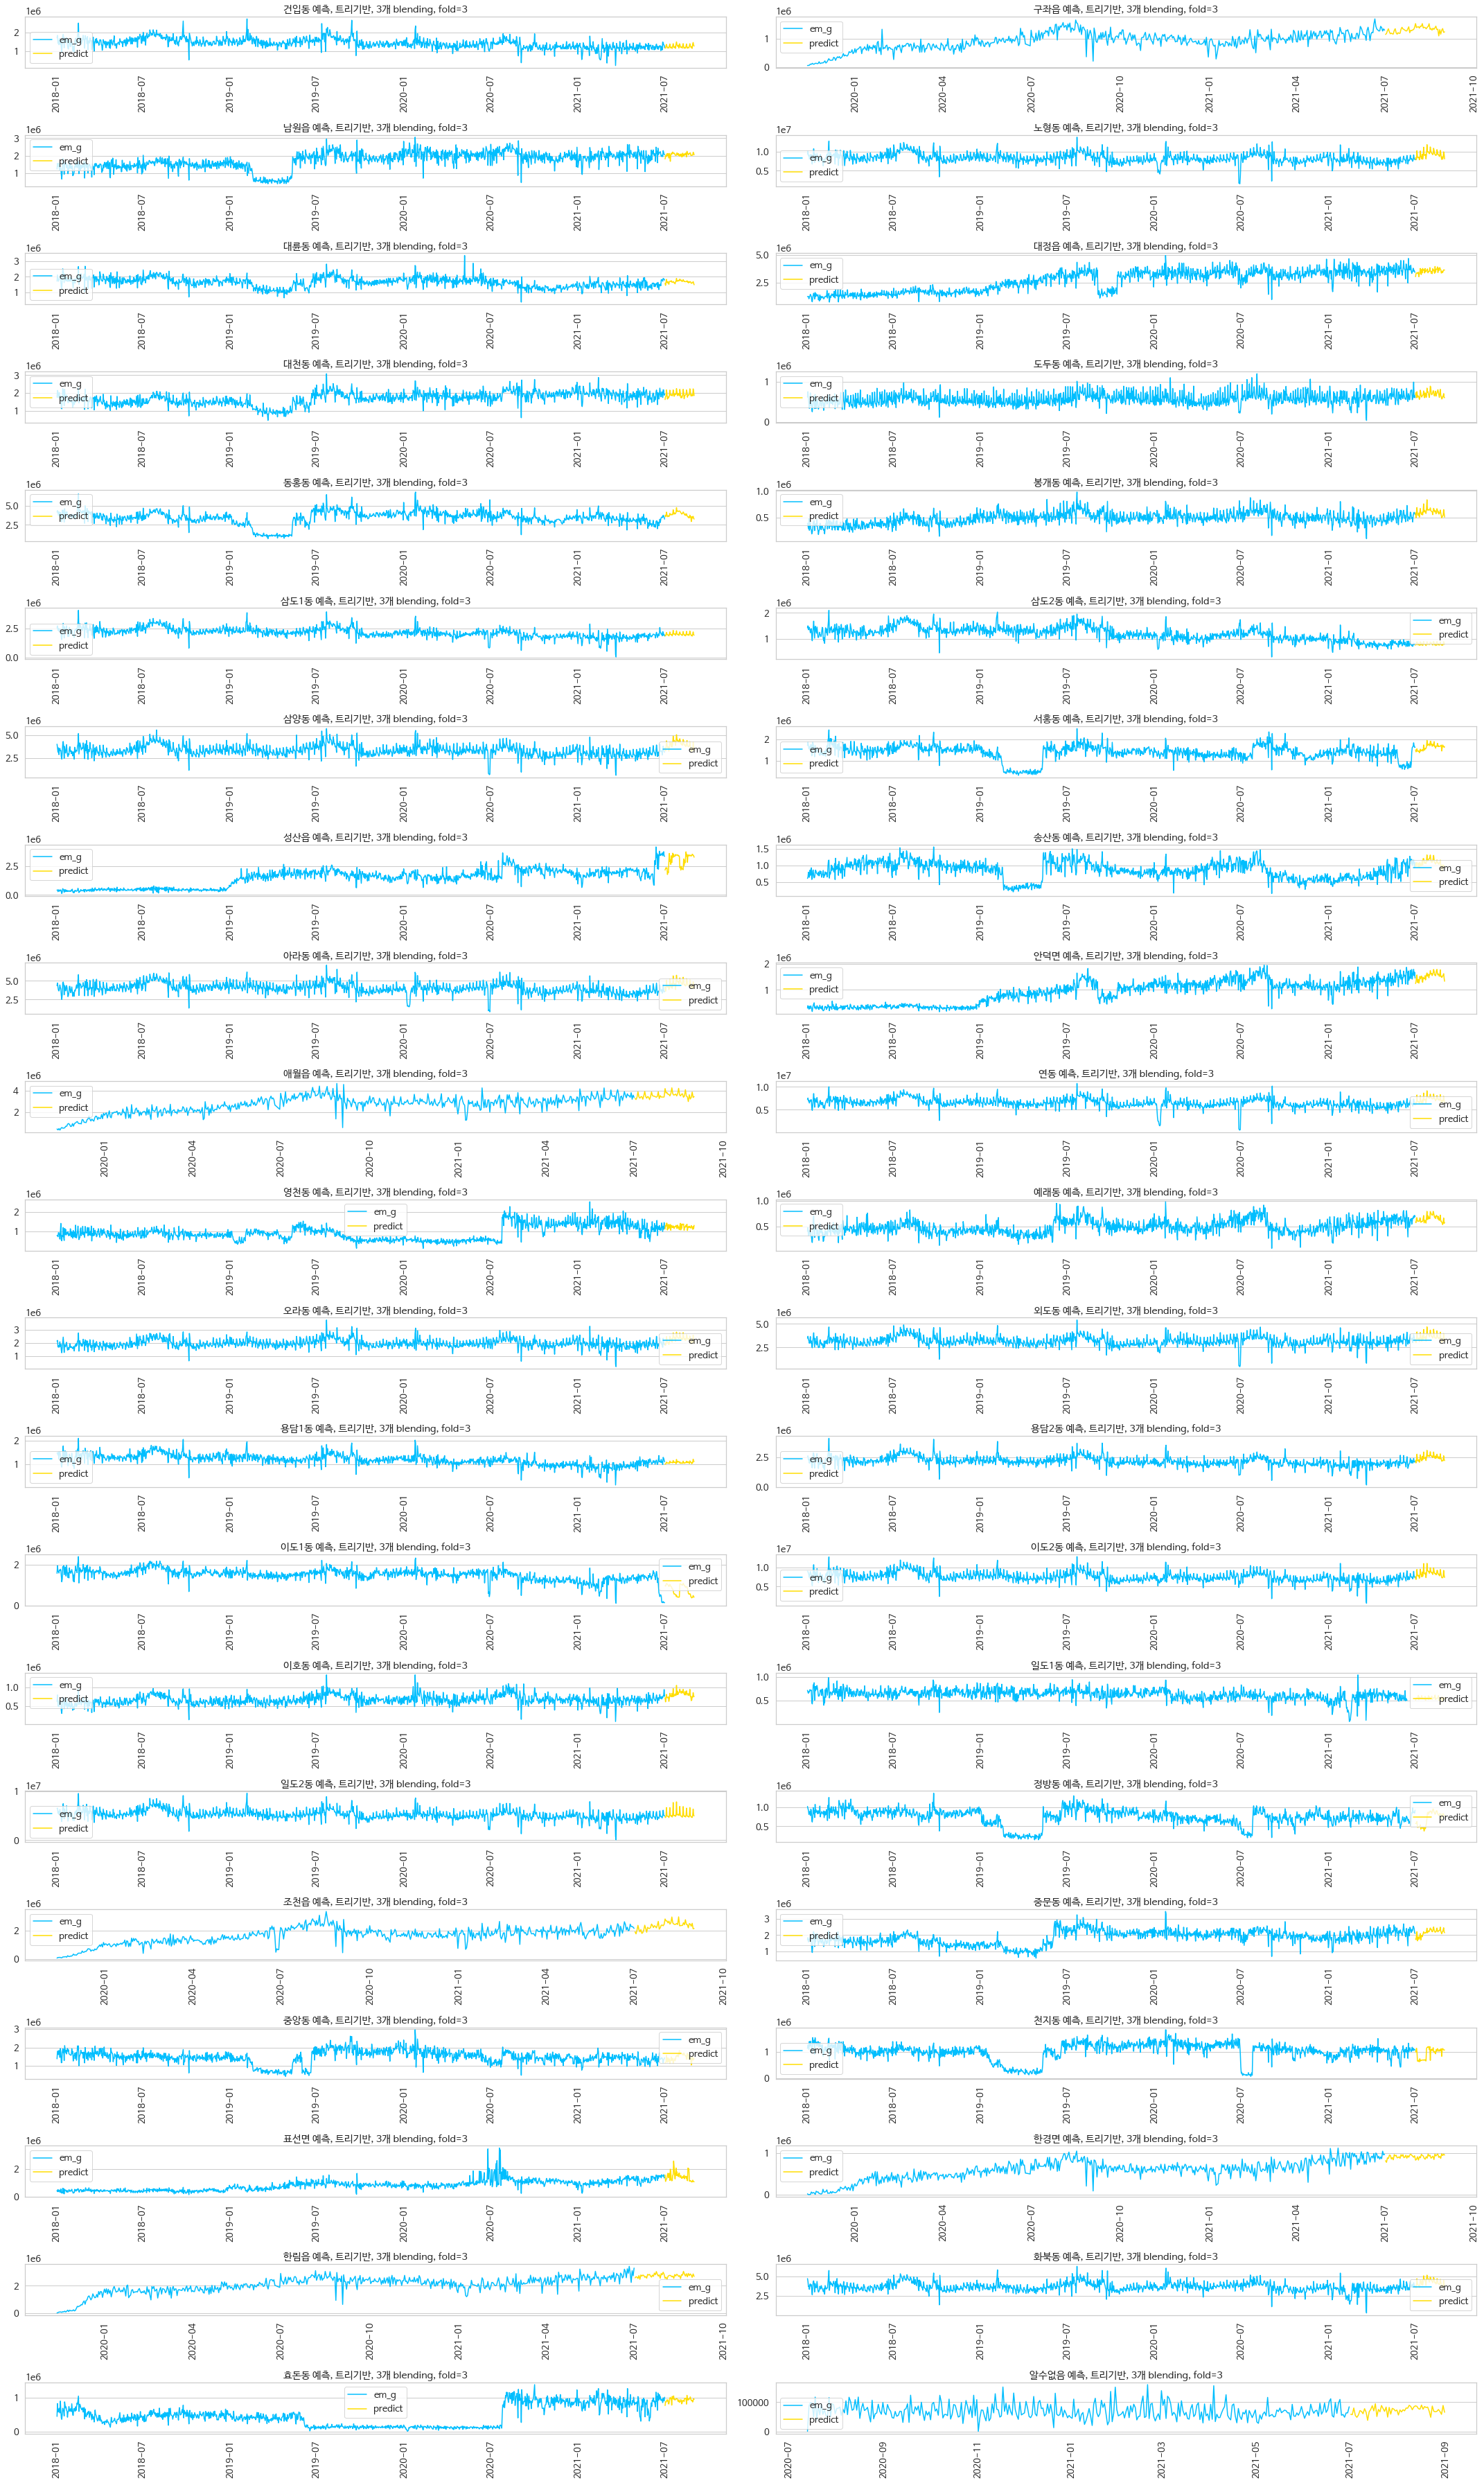

In [4]:
import pandas as pd
import numpy as np
from pycaret.regression import *
np.random.seed(777)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

if __name__ == "__main__":
  # 데이터 불러오기
  data = pd.read_csv(os.path.join('..','preprocessing', 'total_data_final_known_end.csv'))
  unknown_data = pd.read_csv(os.path.join('..','preprocessing', 'total_data_final_unknown_end.csv'))
  data['base_date'] = pd.to_datetime(data['base_date'])
  unknown_data['base_date'] = pd.to_datetime(unknown_data['base_date'])


  # 예측데이터에 사용할 외부데이터 불러오기
  house = pd.read_csv('/content/drive/MyDrive/2021_빅콘테스트/최종 제출본/raw/외부데이터/인구__가구_및_주택__읍면동_2015_2020___시군구_20162019__20210822212745.csv', encoding='CP949', header=None, skiprows = 4)
  house.columns = ['emd_nm', 'single_house', 'apartment', 'small_apartment', 'multi-household_house']
  household = pd.read_csv('/content/drive/MyDrive/2021_빅콘테스트/최종 제출본/raw/외부데이터/가구원수별_가구_일반가구___읍면동_2015_2020___시군구_20162019__20210823014136.csv', encoding = 'CP949', header=None, skiprows = 2)
  household.columns = ['emd_nm', '1_people', '2_people', '3_people', '4_people', '5_people', '6_people', '7_people']

  # 예래동 아파트 X -> 숫자로 바꾸기, 일도1동 7_people X -> 숫자로 바꾸기
  data.apartment[data.emd_nm == '예래동'] = 0
  house.apartment[house.emd_nm == '예래동'] = 0
  data.apartment = data.apartment.astype(float)
  house.apartment = house.apartment.astype(float)
  data['7_people'][data.emd_nm == '일도1동'] = 0
  household['7_people'][household.emd_nm == '일도1동'] = 0
  data['7_people'] = data['7_people'].astype(float)
  household['7_people'] = household['7_people'].astype(float)

  # 사용할 변수 남기기
  var = ['base_date', 'emd_nm', 'year',	'month',	'day',	'week',	'day_of_week',	'season', 'redday',
        'single_house', 'apartment', 'small_apartment', 'multi-household_house',
        '1_people', '2_people', '3_people', '4_people', '5_people', '6_people', '7_people', 'em_g']
  data = data[var]

  var_unknown = ['base_date', 'emd_nm', 'year',	'month',	'day',	'week',	'day_of_week',	'season', 'redday', 'em_g']
  unknown_data = unknown_data[var_unknown]

  # 예측 데이터 만들기
  future_dates = pd.date_range(start = '2021-07-01', end = '2021-08-31')
  future_dates_df = pd.DataFrame(future_dates)
  future_dates_df.columns = ['base_date']

  future_dates_df['base_date'] = pd.to_datetime(future_dates_df['base_date'])
  future_dates_df['year'] = future_dates_df['base_date'].dt.year
  future_dates_df['month'] = future_dates_df['base_date'].dt.month
  future_dates_df['day'] = future_dates_df['base_date'].dt.day
  future_dates_df['week'] = future_dates_df['base_date'].dt.week
  future_dates_df['day_of_week'] = future_dates_df['base_date'].dt.weekday
  future_dates_df['month'] = future_dates_df['month'].astype(str)
  mapping = {"3" : 0, "4" : 0, "5" : 0, "6" : 1, "7" : 1, "8" : 1, "9" : 2, "10" : 2, "11" : 2, "12" : 3, "1" : 3, "2" : 3}   # 봄 = 0
  future_dates_df['season'] = future_dates_df['month'].replace(mapping).astype(int)
  future_dates_df['redday'] = 0

  for i in  range(0, len(future_dates_df)):
    if (future_dates_df['base_date'][i] == '2021-08-14') | (future_dates_df['base_date'][i] == '2021-08-15') | (future_dates_df['base_date'][i] == '2021-08-16'):
      future_dates_df['redday'][i] = 1

  # 지역별 데이터 만들기
  for i in data['emd_nm'].unique():
    globals()['data_{}'.format(i)] = data[data['emd_nm']==i]
    globals()['data_{}'.format(i)].reset_index(drop=True, inplace=True)

  # 지역별 예측 데이터 만들기
  for i in data['emd_nm'].unique():
    globals()['future_dates_df_{}'.format(i)] = future_dates_df

  # 알수없음 추가 처리
  future_dates_df_알수없음 = future_dates_df

  # 지역별 house 데이터 만들기
  for i in data['emd_nm'].unique():
    globals()['house_{}'.format(i)] = house[house.emd_nm==i].drop('emd_nm',axis=1).reset_index(drop=True)

  # 지역별 household 데이터 만들기
  for i in data['emd_nm'].unique():
    globals()['household_{}'.format(i)] = household[household.emd_nm==i].drop('emd_nm',axis=1).reset_index(drop=True)

  # 지역별 예측 데이터에 house 및 household 변수 추가
  for i in data['emd_nm'].unique():
    globals()['future_dates_df_{}'.format(i)] = pd.concat([globals()['future_dates_df_{}'.format(i)], globals()['house_{}'.format(i)]], axis=1)
    globals()['future_dates_df_{}'.format(i)]['single_house'] = globals()['future_dates_df_{}'.format(i)]['single_house'][0]
    globals()['future_dates_df_{}'.format(i)]['apartment'] = globals()['future_dates_df_{}'.format(i)]['apartment'][0]
    globals()['future_dates_df_{}'.format(i)]['small_apartment'] = globals()['future_dates_df_{}'.format(i)]['small_apartment'][0]
    globals()['future_dates_df_{}'.format(i)]['multi-household_house'] = globals()['future_dates_df_{}'.format(i)]['multi-household_house'][0]
    globals()['future_dates_df_{}'.format(i)] = pd.concat([globals()['future_dates_df_{}'.format(i)], globals()['household_{}'.format(i)]], axis=1)
    globals()['future_dates_df_{}'.format(i)]['1_people'] = globals()['future_dates_df_{}'.format(i)]['1_people'][0]
    globals()['future_dates_df_{}'.format(i)]['2_people'] = globals()['future_dates_df_{}'.format(i)]['2_people'][0]
    globals()['future_dates_df_{}'.format(i)]['3_people'] = globals()['future_dates_df_{}'.format(i)]['3_people'][0]
    globals()['future_dates_df_{}'.format(i)]['4_people'] = globals()['future_dates_df_{}'.format(i)]['4_people'][0]
    globals()['future_dates_df_{}'.format(i)]['5_people'] = globals()['future_dates_df_{}'.format(i)]['5_people'][0]
    globals()['future_dates_df_{}'.format(i)]['6_people'] = globals()['future_dates_df_{}'.format(i)]['6_people'][0]
    globals()['future_dates_df_{}'.format(i)]['7_people'] = globals()['future_dates_df_{}'.format(i)]['7_people'][0]

  # 일도1동 : 2021-06-13까지만 사용
  # 한림읍, 애월읍, 구좌읍, 한경면, 조천읍 : 2019-11-12 부터 사용
  data_일도1동 = data_일도1동.iloc[:-5, :]
  data_한림읍 = data_한림읍[data_한림읍['base_date'] >= '2019-11-12']
  data_애월읍 = data_애월읍[data_애월읍['base_date'] >= '2019-11-12']
  data_구좌읍 = data_구좌읍[data_구좌읍['base_date'] >= '2019-11-12']
  data_한경면 = data_한경면[data_한경면['base_date'] >= '2019-11-12']
  data_조천읍 = data_조천읍[data_조천읍['base_date'] >= '2019-11-12']

  data_한림읍.reset_index(inplace=True, drop=True)
  data_애월읍.reset_index(inplace=True, drop=True)
  data_구좌읍.reset_index(inplace=True, drop=True)
  data_한경면.reset_index(inplace=True, drop=True)
  data_조천읍.reset_index(inplace=True, drop=True)

  # 알수없음 : 2020-07-13 부터 사용
  data_알수없음 = unknown_data.iloc[561:,:]
  data_알수없음.reset_index(inplace=True, drop=True)

  # 예측 모형 생성
  submission = pd.date_range(start = '2021-07-01', end = '2021-08-31')
  submission = pd.DataFrame(submission)
  submission.columns = ['base_date']

  # 제주시 + 서귀포시
  for i in data['emd_nm'].unique():
    s = setup(data = globals()['data_{}'.format(i)], train_size = 0.95, target = 'em_g', log_experiment=True,
              data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3, remove_outliers=True,
              ignore_features = ['base_date', 'emd_nm'], silent = True, verbose = False, session_id = 777)
    compare = compare_models(include=['lightgbm','dt','rf','et'], n_select=3 , verbose = False)
    save_model(compare, os.path.join('..','model', 'compare_model_'+i), verbose = False)    
    blend = blend_models(compare, verbose = False)
    blend = finalize_model(blend)
    save_model(blend, os.path.join('..','model', 'model_'+i), verbose = False)
    globals()['forcast_{}'.format(i)] = predict_model(load_model(os.path.join('..','model', 'model_'+i), verbose = False), data=globals()['future_dates_df_{}'.format(i)])
    globals()['forcast_{}'.format(i)].rename(columns = {'Label' : i}, inplace = True)

    submission = pd.concat([submission, pd.DataFrame(globals()['forcast_{}'.format(i)][i])], axis=1)

  # 알수없음
  s = setup(data = data_알수없음, train_size = 0.95, target = 'em_g', log_experiment=True,
              data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3, remove_outliers=True,
              ignore_features = ['base_date', 'emd_nm'], silent = True, verbose = False, session_id = 777)
  compare = compare_models(include=['lightgbm','dt','rf','et'], n_select=3 , verbose = False)
  save_model(compare, os.path.join('..','model', 'compare_model_알수없음'), verbose = False)
  blend = blend_models(compare, verbose = False)
  blend = finalize_model(blend)
  save_model(blend, os.path.join('..','model', 'model_알수없음'), verbose = False)
  forcast_알수없음 = predict_model(load_model(os.path.join('..','model', 'model_알수없음'), verbose = False), data=future_dates_df_알수없음)
  forcast_알수없음.rename(columns = {'Label' : '알수없음'}, inplace = True)
  submission = pd.concat([submission, pd.DataFrame(forcast_알수없음['알수없음'])], axis=1)

  # 제출 데이터 생성
  july = submission[submission['base_date'] <= "2021-07-31"]
  august = submission[submission['base_date'] > "2021-07-31"]
  august.reset_index(inplace=True, drop=True)

  emd = sorted(data['emd_nm'].unique())
  emd.append('알수없음')
  sub = pd.DataFrame(emd)
  sub.columns = ['emd_nm']
  sub['em_g_7'] = 0
  sub['em_g_8'] = 0

  sub.set_index(['emd_nm'], inplace=True)
  for i in emd:
    sub.loc[i, 'em_g_7'] = july[i].sum()
    sub.loc[i, 'em_g_8'] = august[i].sum()
    round(sub.loc[i, 'em_g_7'], 1)
    round(sub.loc[i, 'em_g_8'], 1)

  sub.reset_index(inplace=True)
  sub.to_csv(os.path.join('..','predict', 'submission.csv'))

  fig = plt.figure(figsize=(30,50))
  plt.rc('font', family='NanumBarunGothic') 
  for i in range(len(emd)):
    plt.subplot(21,2,i+1)
    plt.plot(globals()['data_{}'.format(emd[i])].set_index('base_date')['em_g'], label='em_g')
    plt.plot(submission.set_index('base_date')[emd[i]], label='predict')
    plt.xticks(rotation=90)
    plt.title(emd[i]+" 예측, 트리기반, 3개 blending, fold=3")
    plt.grid(axis='x')
    plt.legend()
  fig.tight_layout()